In [2]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# from ipywidgets import Button, HBox, VBox, Output
from IPython.display import display
import pickle 
from matplotlib.path import Path
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
import cv2

import glob
import json
import os
import h5py

import torch
from torchvision import transforms, models
from PIL import Image
from sklearn.cluster import DBSCAN
import numpy as np
import shutil

from sklearn.decomposition import PCA

from utils import show_mirror

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
%reload_ext autoreload

In [3]:
PATH_GPU = "/home/pgliwny/computer_vision_project/data"
PATH_ADATA = "/media/pgliwny/ADATA HD330/Computer_vision_for_MAGIC/prepare_images/data"
H5_PATH = os.path.join(PATH_GPU, "webcam_images.h5")

In [5]:
with h5py.File(H5_PATH, "r") as f:
    for entry_name in f["images"]:
        entry = f["images"][entry_name]
        image = entry["image"][:]
        name = entry["image_name"][()].decode("utf-8")
        
        mirrors = []
        for mirror_name in entry["mirrors"]:
            mirrors.append(entry["mirrors"][mirror_name][:])

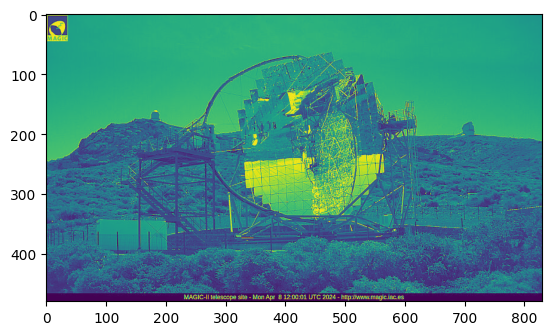

In [7]:
plt.imshow(image)

0 entry_0
1 entry_1
2 entry_10
3 entry_100
4 entry_101
5 entry_102
6 entry_103
7 entry_104
8 entry_105
9 entry_106


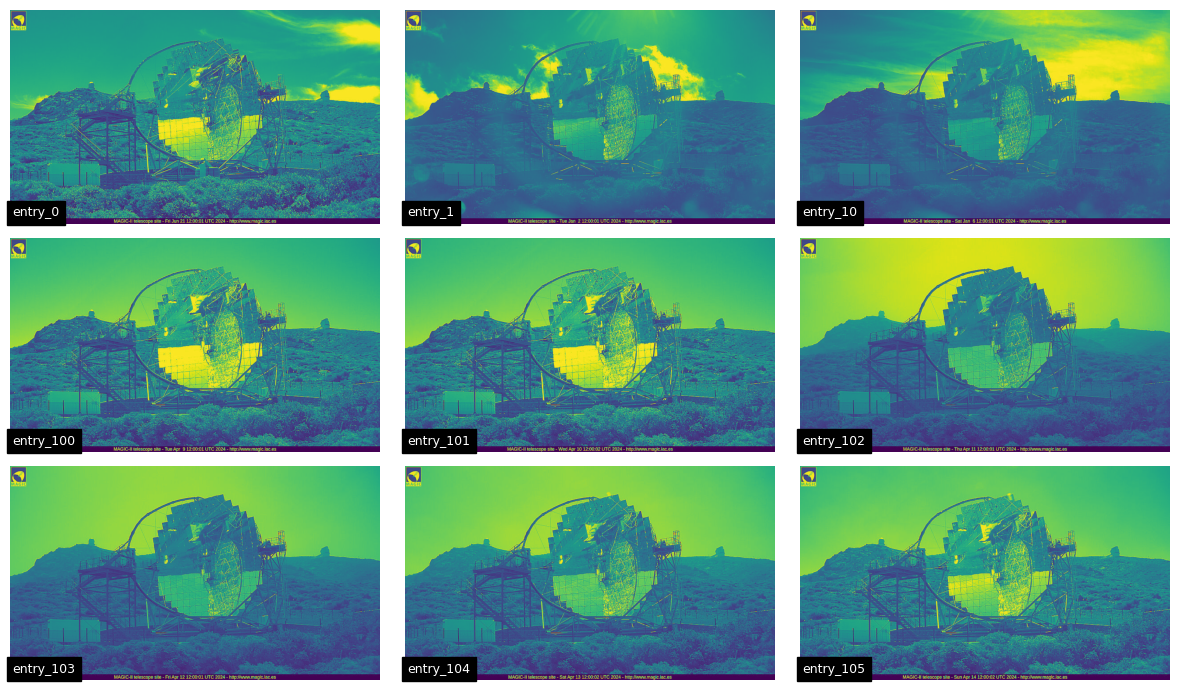

In [38]:
fig, ax = plt.subplots(3, 3, figsize=(12, 7))
ax = ax.flatten()

with h5py.File(H5_PATH, "r") as f:
    for i, entry_name in enumerate(f["images"]):
        print(i, entry_name)
        if i >= 9:
            break
        entry = f["images"][entry_name]
        image = entry["image"][:]
        ax[i].imshow(image)
        ax[i].axis("off")
        # Add label on the image (bottom-left corner)
        ax[i].text(
            5,                          # x-coordinate in pixels
            image.shape[0] - 10,        # y-coordinate in pixels (from top)
            entry_name, 
            color="white", 
            fontsize=9, 
            backgroundcolor="black",
            ha="left", 
            va="bottom"
        )
plt.tight_layout()
plt.show()

# Save web images to pdf

In [47]:
BATCH_SIZE = 9
MAX_IMAGES = 210

with h5py.File(H5_PATH, "r") as f, PdfPages("image_batches.pdf") as pdf:
    image_names = list(f["images"].keys())[:MAX_IMAGES]  # Select first 36 images

    for batch_start in range(0, len(image_names), BATCH_SIZE):
        fig, ax = plt.subplots(3, 3, figsize=(12, 7))
        ax = ax.flatten()

        for i in range(BATCH_SIZE):
            idx = batch_start + i
            if idx >= len(image_names):
                break
            name = image_names[idx]
            image = f["images"][name]["image"][:]
            list_entry.append(name)

            ax[i].imshow(image, cmap="gray")
            ax[i].axis("off")
            ax[i].text(
                5,
                image.shape[0] - 10,
                name,
                color="white",
                fontsize=9,
                backgroundcolor="black"
            )

        # Hide any unused axes (e.g., last page might not be full)
        for j in range(i + 1, len(ax)):
            ax[j].axis("off")

        plt.tight_layout()
        pdf.savefig(fig)  # Save current figure to PDF
        plt.close(fig)    # Close the figure to free memory

In [11]:
output_txt = "entries_image_name.txt"
output_json = "entries_image_name.json"

entries_dict = {}

with h5py.File(H5_PATH, "r") as f, open(output_txt, "w", encoding="utf-8") as txt_file:
    for entry_name in f["images"]:
        image_name = f["images"][entry_name]["image_name"][()].decode("utf-8")
    
        txt_file.write(f"{entry_name}: {image_name}\n")
    
        entries_dict[entry_name] = image_name

In [12]:
# Zapisz do pliku JSON
with open(output_json, "w", encoding="utf-8") as json_file:
    json.dump(entries_dict, json_file, ensure_ascii=False, indent=4)

In [4]:
f = h5py.File(H5_PATH, "r")

In [5]:
WEBCAM_IMG_PATH = "/media/pgliwny/ADATA HD330/Computer_Vision_system/data/MAGIC/webcam/"
image_list = glob.glob(os.path.join(WEBCAM_IMG_PATH,"image_2024*"))
print(image_list[:3])

[]


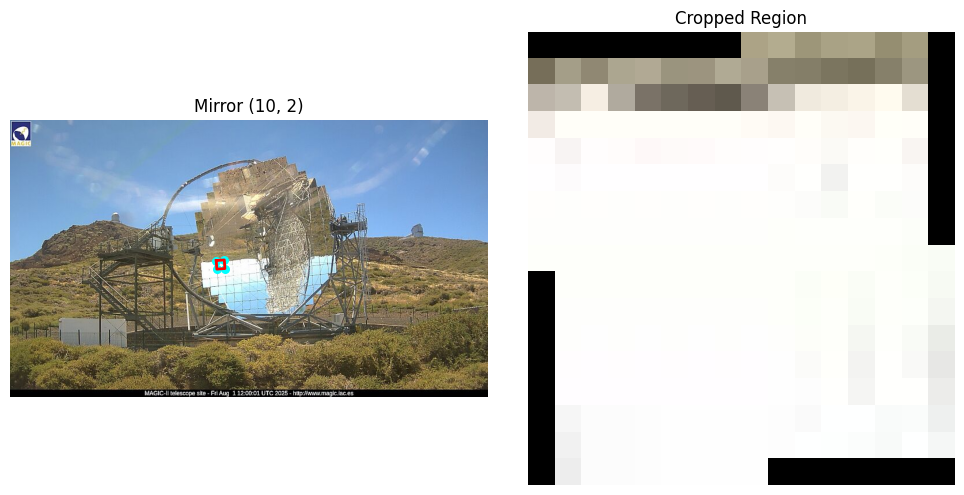

In [9]:
show_mirror("data/1200_la.jpg", 172)

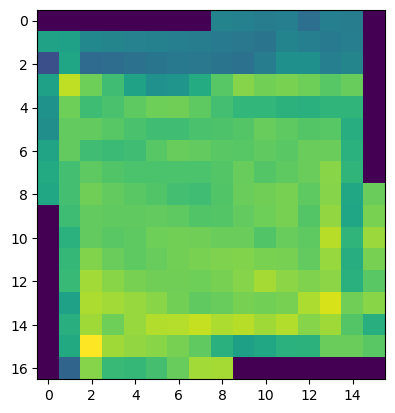

In [56]:
plt.imshow(f["images"]['entry_95']['mirrors']['mirror_172'][:])

# Clustering

In [7]:
feats = []
for entry_name in f["images"]:
    img_array = f["images"][entry_name]['mirrors']['mirror_172'][:].flatten()/255
    feats.append(img_array)

feats = np.stack(feats)

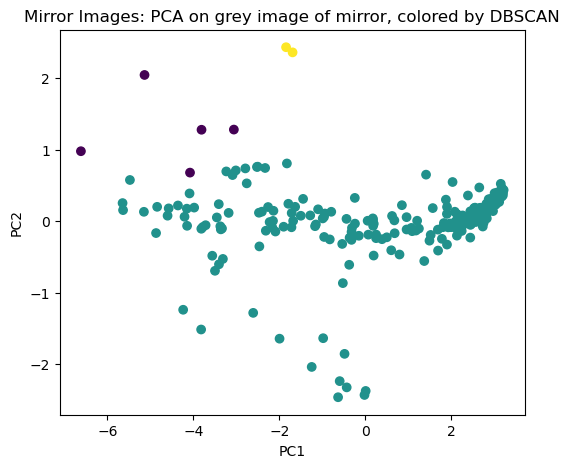

In [8]:
# 3. Reduce to 2D for plotting
pca = PCA(n_components=2)
proj = pca.fit_transform(feats)

# 4. Cluster with DBSCAN (eps/min_samples may need tuning)
clust = DBSCAN(eps=1.75, min_samples=2).fit(feats)
labels = clust.labels_  # -1 = anomaly, 0,1,2… = clusters

# 5. Scatter‐plot
plt.figure(figsize=(6,5))
plt.scatter(proj[:,0], proj[:,1], c=labels)
plt.title("Mirror Images: PCA on grey image of mirror, colored by DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [8]:
for label, entry_name in zip(labels, f["images"]):
    if label == -1:
        print(entry_name, label)

entry_127 -1
entry_128 -1
entry_129 -1
entry_130 -1
entry_136 -1


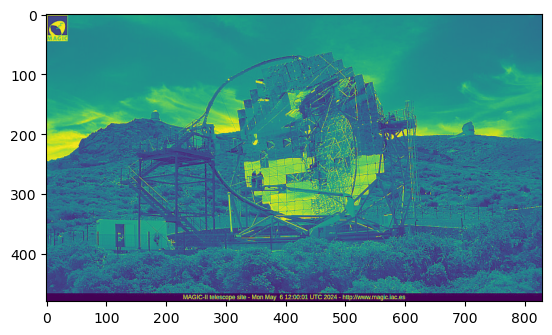

In [18]:
plt.imshow(f["images"]['entry_127']["image"][:])

In [13]:
name_bytes = f["images"]["entry_129"]["image_name"][()]  # odczytanie danych
image_name = name_bytes.decode("utf-8")  # dekodowanie bajtów do stringa
print("Image name:", image_name)

Image name: image_2024-05-08_1200.jpg
